# Phase 1
### - Read wm 
### - Read mm
### - Read Sync test

# some questions:

1. What units is the acceleromter generating?
<font color=red> Ans: data file implies (g). Need to convert to m/sec2
2. Do I need to remove the effects of acceleration due to gravity? (https://stackoverflow.com/questions/6085583/how-can-i-find-the-velocity-using-accelerometers-only)
3. Do I need to account for sensor rotation? (https://stackoverflow.com/questions/6085583/how-can-i-find-the-velocity-using-accelerometers-only)
4. Should the scales for both acclerations (RF and accelerometer) be the same if they have the same units??

# Resources
- https://www.youtube.com/watch?v=eqZgxR6eRjo (how IMUs work)
- https://www.youtube.com/watch?v=0rlvvYgmTvI (How to do sensor fusion)

## Sensor orientation

### MM: https://docs.google.com/presentation/d/1Rdox_xnmT3ixkT-CzPN4canIJqrt_pWd/edit#slide=id.p1
### WM: 

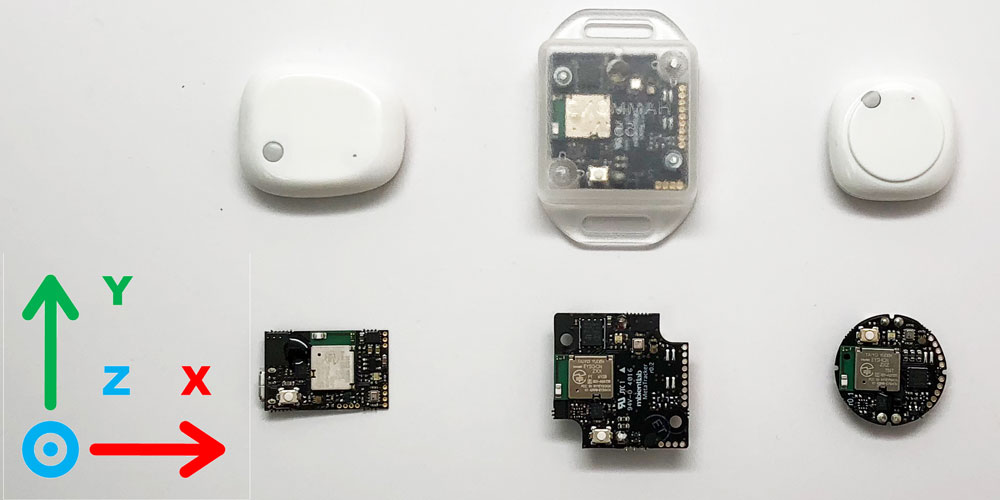

 ### &#9658; <font color=red> Observation: Both are aligned (but wm needs 180 degree rotation)

## Helpful links from mbientlab 
python tutorials: https://mbientlab.com/tutorials/Orientation.html

data sheet: https://www.bosch-sensortec.com/products/motion-sensors/imus/bmi270/

In [31]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [52]:
# read mm
import sys
sys.path.append("/Users/calvinperumalla/git/ir_project/library")
import os
from datetime import datetime, timedelta
from fileload_utils import *
from metrics_utils import *

In [33]:
# 
imu_readpath = "/Users/calvinperumalla/datasets/imu_vs_mm_Feb14/mmVsImu/imu/*"
mm_readpath = "/Users/calvinperumalla/datasets/imu_vs_mm_Feb14/mmVsImu/mm/*"


In [34]:
from glob import glob
mm_files = glob(mm_readpath)
mm_files

['/Users/calvinperumalla/datasets/imu_vs_mm_Feb14/mmVsImu/mm/idletime_10s_roughly',
 '/Users/calvinperumalla/datasets/imu_vs_mm_Feb14/mmVsImu/mm/y_only',
 '/Users/calvinperumalla/datasets/imu_vs_mm_Feb14/mmVsImu/mm/x_only',
 '/Users/calvinperumalla/datasets/imu_vs_mm_Feb14/mmVsImu/mm/pth',
 '/Users/calvinperumalla/datasets/imu_vs_mm_Feb14/mmVsImu/mm/sync',
 '/Users/calvinperumalla/datasets/imu_vs_mm_Feb14/mmVsImu/mm/z_only']

In [35]:
def load_motion_data_from_cubes_2test(data_filename,sensor_orientation, sensorCount):
    time = []
    timestamps = []
    t = 0
    X = []
    Y = []
    Z = []
    
    Az = []
    El = []
    Ro = []
    
    ignore_to = 20 # number of samples to ignore in the beginning
    with open(data_filename, 'r') as fh:
        lines = fh.read().splitlines()
        data = []
        for line in lines[1 + ignore_to:]:
            l_arr = []
            x_arr = []
            y_arr = []
            z_arr = []
            
            az_arr = []
            el_arr = []
            roll_arr = []
            
            for i, l in enumerate(filter(lambda x: x!='', line.split(' '))):
                #print(line)
                if 'Sensor' in l or '0x' in l:
                    continue
                
                if (i - 2) % 11 == 0:
                    x_arr.append(l)
                if (i - 3) % 11 == 0:
                    y_arr.append(l)
                if (i - 4) % 11 == 0:
                    z_arr.append(l)
                    
                if (i - 5) % 11 == 0:
                    az_arr.append(l)
                if (i - 6) % 11 == 0:
                    el_arr.append(l)
                if (i - 7) % 11 == 0:
                    roll_arr.append(l)
                # time 
                if (i-10) % 11 == 0:
                    ts  = float(l)
                    
            X.append(x_arr)
            Y.append(y_arr)
            Z.append(z_arr)
            
            Az.append(az_arr)
            El.append(el_arr)
            Ro.append(roll_arr)
            time.append(t)
            timestamps.append(ts)
            t += 1
        X = np.array(X, dtype=float)/1000  # converting mm to meter
        Y = np.array(Y, dtype=float)/1000  # converting mm to meter
        Z = np.array(Z, dtype=float)/1000  # converting mm to meter

        Az = np.array(Az, dtype=float)  # converting mm to meter
        El = np.array(El, dtype=float)  # converting mm to meter
        Ro = np.array(Ro, dtype=float)  # converting mm to meter

        time = np.array(time)/100
        
    return 100, np.array(time/100), timestamps, X, Y, Z, Az, El, Ro

In [36]:
mm_files[0]

'/Users/calvinperumalla/datasets/imu_vs_mm_Feb14/mmVsImu/mm/idletime_10s_roughly'

In [37]:
sensor_orientation = [0]
sampling_freq,time_n, ts_n, X_n,Y_n,Z_n, Az, El, Ro = load_motion_data_from_cubes_2test(mm_files[0], sensor_orientation, 1)

In [38]:
#data = {{[{}, {}]}}

In [39]:
from datetime import datetime
def convert(s, ms=False):
    denom = 1
    if ms:
        denom = 1000
    return datetime.fromtimestamp(s/denom)

In [40]:
data = {}
for fname in glob(mm_readpath):
    sampling_freq, time, ts, X, Y, Z, Az, El, Ro = load_motion_data_from_cubes_2test(fname, sensor_orientation=[0], sensorCount=1)
    mode = fname.split('/')[-1]
    elems = [{'x':X[i,0], 'y':Y[i,0], 'z':Z[i,0], 'ts':convert(ts[i])} for i in range(X.shape[0])]
    elems_eu = [{'a':Az[i,0], 'e':El[i,0], 'r':Ro[i,0], 'ts':convert(ts[i])} for i in range(X.shape[0])]
    data[mode] = {'mm': elems}
    data[mode].update({'eu': elems_eu})

In [41]:
data.keys()

dict_keys(['idletime_10s_roughly', 'y_only', 'x_only', 'pth', 'sync', 'z_only'])

## reading wireless motion data

In [42]:
def read_imu(file_name):
    elems = []
    with open(file_name, 'r') as fh:
        lines = fh.read().splitlines()[1:]
        for line in lines:
            l = line.split(',')
            ts = float(l[0])
            x = float(l[-3])
            y = float(l[-2])
            z = float(l[-1])
            elems.append({'x':x, 'y':y, 'z':z, 'ts':convert(ts, ms=True)})
    return elems

In [43]:
wm_files = glob(imu_readpath)

In [46]:
data.keys()

dict_keys(['idletime_10s_roughly', 'y_only', 'x_only', 'pth', 'sync', 'z_only'])

In [47]:
valid_imu_file_names = ['idletime_10s_roughly',
 'y_only',
 'x_only',
 'pth',
 'sync',
 'z_only']

In [48]:
for folder_name in os.listdir(imu_readpath[:-2]):
    if folder_name not in valid_imu_file_names:
        continue
    assert folder_name in data, folder_name
    for file_path in glob(os.path.join(imu_readpath[:-2], folder_name) + '/*'):        
        if 'Acc' in file_path:
            data[folder_name]['acc'] = read_imu(file_path)
        if 'Gyr' in file_path:
            data[folder_name]['gyr'] = read_imu(file_path)
        else:
            data[folder_name]['mag'] = read_imu(file_path)

## Sync test

data = {
    'idletime_10s_roughly' : {
                'acc': [{'x': 'y':, 'z':, 'ts':}, {'x': 'y':, 'z':, 'ts':}, ...]
            }
}


data = {
    'idletime_10s_roughly' : {
                'acc': [{'x': 'y':, 'z':, 'ts':}, {'x': 'y':, 'z':, 'ts':}, ...]
            }
}


In [49]:
def get_data(key, srate, filthigh=True, time_delta_secs=0):
    g = 9.81 # accelaration due to gravity
    if filthigh:
        _get_d = lambda x, y: g * np.array(butter_lowpass_filter([elem[x] for elem in data[key][y] if elem['ts'] > st and elem['ts'] < end], 5, srate,3))
    else:
        _get_d = lambda x, y: np.array([elem[x] for elem in data[key][y] if elem['ts'] > st and elem['ts'] < end])
    
    time_delta_ms = timedelta(seconds=time_delta_secs)    
    st = max(data[key]['acc'][0]['ts'], data[key]['mm'][0]['ts'])
    end = min(data[key]['acc'][-1]['ts'], data[key]['mm'][-1]['ts'])
    
    time_i = [(elem['ts'] + time_delta_ms) for elem in data[key]['acc'] if elem['ts'] > st and elem['ts'] < end]
    time_m = [elem['ts'] for elem in data[key]['mm'] if elem['ts'] > st and elem['ts'] < end]
    
    x_a = g * _get_d('x', 'acc')
    y_a = g * _get_d('y', 'acc')
    z_a = g * _get_d('z', 'acc')

    x_m = _get_d('x', 'mm')
    y_m = _get_d('y', 'mm')
    z_m = _get_d('z', 'mm')
    
    x_g = _get_d('x', 'gyr')
    y_g = _get_d('y', 'gyr')
    z_g = _get_d('z', 'gyr')

    a_e = _get_d('a', 'eu')
    e_e = _get_d('e', 'eu')
    r_e = _get_d('r', 'eu')

    
    
    return time_m, x_m, y_m, z_m, time_i, x_a, y_a, z_a, x_g, y_g, z_g, a_e, e_e, r_e



In [53]:
t_m, x_m, y_m, z_m, t_i, x_a, y_a, z_a, x_g, y_g, z_g, a_eu, e_eu, r_eu = get_data('sync', srate=100)

In [54]:
def get_angular_vel(a, e, r):    
    a = np.reshape(a, (len(a), 1))
    e = np.reshape(e, (len(e), 1))
    r = np.reshape(r, (len(r), 1))
    aeu_vel, _ = numDiff(a, params)
    eeu_vel, _ = numDiff(e, params)
    reu_vel, _ = numDiff(r, params)
    return np.sqrt((np.square(aeu_vel)) + (np.square(eeu_vel)) + (np.square(reu_vel)))

In [55]:
def get_norm(x, y, z, nump=True):
    if not nump:
        x = np.array(x)
        y = np.array(y)
        z = np.array(z)
    mat = np.array([x, y, z]).T
    return np.linalg.norm(mat, axis=1)

In [56]:
ang_mag_eu = get_angular_vel(a_eu,e_eu,r_eu)
ang_mag_gyr = get_norm(x_g, y_g, z_g)

NameError: name 'params' is not defined

In [ ]:
# plt.plot(t_m, ang_mag_eu)
# plt.plot(t_i, 0.1 * ang_mag_gyr + 1300)
# plt.xlim(datetime(2023, 2, 14, 14, 46, 42, 601000), datetime(2023, 2, 14, 14, 46, 43, 601000))
plt.plot(t_m, ang_mag_eu)
plt.plot(np.array(t_i) + delta, ang_mag_gyr)

plt.xlim(datetime(2023, 2, 14, 14, 46, 44, 601000), datetime(2023, 2, 14, 14, 46, 45, 601000))

In [ ]:
print(max(ang_mag_eu))
print(min(ang_mag_eu))
print(max(ang_mag_gyr))
print(min(ang_mag_gyr))

In [ ]:
# get time stamps for sync mode
# st = data['sync']['wm'][0]['ts']
# end = data['sync']['wm'][-1]['ts']

st = max(data['sync']['acc'][0]['ts'], data['sync']['eu'][0]['ts'])
end = min(data['sync']['acc'][-1]['ts'], data['sync']['eu'][-1]['ts'])

gyr_times = [elem['ts'] for elem in data['sync']['gyr'] if elem['ts'] > st and elem['ts'] < end]
eu_times = [elem['ts'] for elem in data['sync']['eu'] if elem['ts'] > st and elem['ts'] < end]

acc_vals = [elem['y'] for elem in data['sync']['gyr'] if elem['ts'] > st and elem['ts'] < end]
mm_vals = [elem['a'] for elem in data['sync']['eu'] if elem['ts'] > st and elem['ts'] < end]

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
# from collections import Counter
# c = Counter(int(d.timestamp()) for d in mm_times)

In [ ]:
# i, j = zip(*(c.items()))
# plt.plot(i, j)

In [ ]:
type(mm_vals)

In [ ]:
from datetime import timedelta
s = 0 
e = 1500
acc_times_ad = [d + timedelta(seconds= -0.29) for d in acc_times]
plt.plot(mm_times[s:e], np.array(mm_vals[s:e])) # blue
#plt.plot(wm_times[s:e], wm_vals[s:e], alpha = 0.5) # orange
plt.plot(acc_times[s:e], acc_vals[s:e], alpha = 0.5) 

# plt.plot(list(np.zeros(677)) + mm_vals[s:e])
# plt.plot(wm_vals[s:e])
# plt.axvline(900)
# plt.xlim(0, 2000)

In [ ]:
import numpy as np
corr = np.correlate(ang_mag_eu, ang_mag_gyr, mode='full')

In [ ]:
plt.plot(corr)
mx = np.argmax(corr)
plt.axvline(mx)
print(mx)

In [ ]:
time_delta_seconds = (len(ang_mag_eu)  - np.argmax(corr))/100 # sampling rate

In [58]:
time_delta_seconds 

NameError: name 'time_delta_seconds' is not defined

# Phase 2: metric calculation

------------------------------> wm signal lags the mm signal by 10 milliseconds <-------------------------------------

## Idle Time - 10 seconds

In [59]:
params = {'SamplingFrequency': 100, 'HighCutoffFreq': 7.0, 'ButterOrder': 2, 'IdleVelocityThreshold':120, 'PauseDuration':0.5}

In [60]:
def get_imu(key):
    time = [elem['ts'] for elem in data[key]['acc']]
    x = [elem['x'] for elem in data[key]['acc']]
    y = [elem['y'] for elem in data[key]['acc']]
    z = [elem['z'] for elem in data[key]['acc']]
    return time, x, y, z

def get_mm(key):
    time = [elem['ts'] for elem in data[key]['mm']]
    x = [elem['x'] for elem in data[key]['mm']]
    y = [elem['y'] for elem in data[key]['mm']]
    z = [elem['z'] for elem in data[key]['mm']]
    return time, x, y, z

In [61]:
data['idletime_10s_roughly'].keys()

dict_keys(['mm', 'eu', 'acc', 'mag', 'gyr'])

In [69]:
t_m, x_m, y_m, z_m, t_i, x_a, y_a, z_a, x_g, y_g, z_g, a_eu, e_eu, r_eu = get_data('idletime_10s_roughly', srate=100, time_delta_secs=-0.01)
x_raw = [i['y'] for i in data['idletime_10s_roughly']['gyr']]
y_raw = [i['x'] for i in data['idletime_10s_roughly']['gyr']]
z_raw = [i['z'] for i in data['idletime_10s_roughly']['gyr']]

ang_mag_eu = get_angular_vel(a_eu,e_eu,r_eu)
ang_mag_gyr = get_norm(x_g, y_g, z_g)
ang_mag_gyr_raw = get_norm(x_raw, y_raw, z_raw)


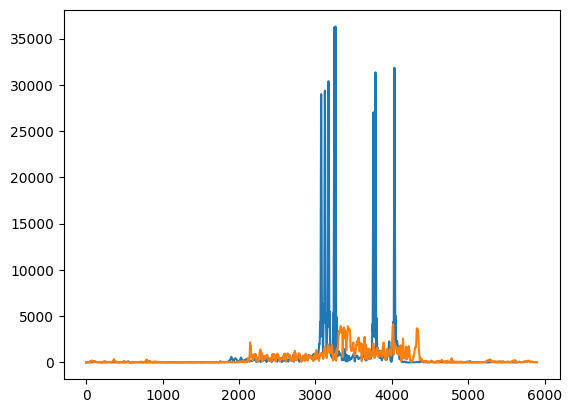

In [67]:
#plt.scatter(list(range(len(ang_mag_gyr))), ang_mag_gyr) 
from matplotlib import pyplot as plt

plt.plot(ang_mag_eu)
#plt.plot(ang_mag_gyr[600: 3300])
plt.plot(20 * ang_mag_gyr_raw)

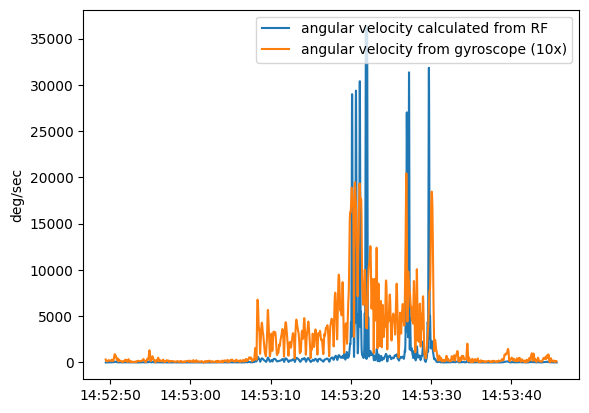

In [71]:
plt.plot(t_m, ang_mag_eu, label='angular velocity calculated from RF')
plt.plot(t_i, 10 *ang_mag_gyr, label='angular velocity from gyroscope (10x)')
plt.ylabel('deg/sec')
plt.legend()

Text(0, 0.5, 'deg/sec')

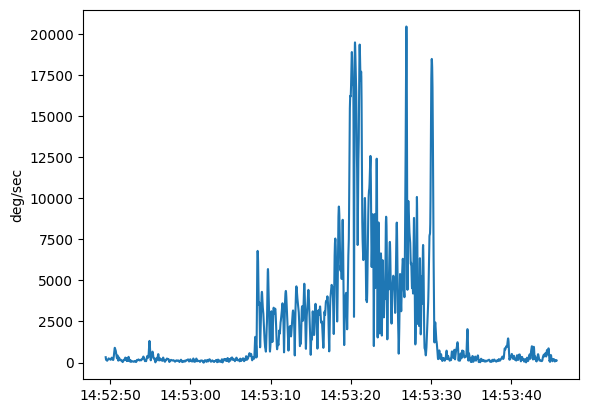

In [72]:
plt.plot(t_i, 10 *ang_mag_gyr,)
plt.ylabel('deg/sec')

## idle time calculation for motion monitoring system

In [172]:
'''def numDiff(data,parameters):
    fs = parameters['SamplingFrequency']
    T = 1/fs
    cutoff = parameters['HighCutoffFreq']
    order = parameters['ButterOrder']
'''

"def numDiff(data,parameters):\n    fs = parameters['SamplingFrequency']\n    T = 1/fs\n    cutoff = parameters['HighCutoffFreq']\n    order = parameters['ButterOrder']\n"

In [73]:

x_mat = np.reshape(x_m, (len(x_m), 1))
y_mat = np.reshape(x_m, (len(y_m), 1))
z_mat = np.reshape(x_m, (len(z_m), 1))

In [74]:
vel_x, acc_x = numDiff(x_mat, params)
vel_y, acc_y = numDiff(y_mat, params)
vel_z, acc_z = numDiff(z_mat, params)
vel_res = np.sqrt((np.square(vel_x)) + (np.square(vel_y)) + (np.square(vel_z)))

Text(0.5, 1.0, 'magnitude')

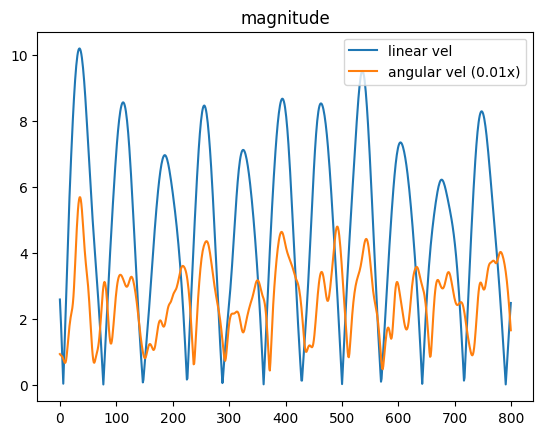

In [75]:
plt.plot(vel_res[2000:2800], label='linear vel')
# magnitude of angular velocity 
ang_mag = 0.01 * np.sqrt((np.square(x_g)) + (np.square(y_g)) + (np.square(z_g)))
plt.plot(ang_mag[2000:2800], label='angular vel (0.01x)')
plt.legend()
plt.title('magnitude')

In [76]:
# Generate Idle Time Function
def generate_Idle_time(vel_res, parameters):
    threshold = parameters['IdleVelocityThreshold']/1000 # convert value to m/sec
    sf = parameters['SamplingFrequency']
    pause_duration = parameters['PauseDuration']
    
    mHand = vel_res
    
    # Convert pause duration into a sample window size based on sampling frequency
    Du = int(pause_duration*sf)
    
    
        
    # Calculate instances in which the velocity is below the velocity threshold
    a = np.zeros(len(mHand))
    
    for i in range(len(a)):
        if mHand[i] < threshold:
            a[i] = 1
            
    idle_instances = a

    # Caculate the toal time by adding time based on if the total duration of idle >= the pause duration
    b = np.ones(int(Du))
    
    c = np.convolve(a,b)


    totalTime = 0
    for i in range(1,len(c)):
        if c[i] == Du and c[i- 1] != Du:
            totalTime = totalTime + Du
        elif c[i] == Du and c[i - 1] == Du:
            totalTime = totalTime + 1
    
    # convert time into seconds by taking the number of samples divided by the sampeling frequency
    total_idle_time = float(totalTime/sf)
    
    # Cacluate the periods in which idle time occurs
    idle_periods = np.zeros(len(a))
    
    for i in range(Du,len(a)):
        if np.sum(a[i-Du:i]) == Du:
            idle_periods[i] = 1
    
    
    return total_idle_time,idle_instances,idle_periods

In [128]:
########################################## CALCULATING IDLE TIME based on MM #########################################

In [78]:
print(params)

{'SamplingFrequency': 100, 'HighCutoffFreq': 7.0, 'ButterOrder': 2, 'IdleVelocityThreshold': 120, 'PauseDuration': 0.5}


Text(0.5, 1.0, 'idle time periods, threshold:120 deg sec, pause duration: 0.5 seconds; total idle time: 26.14')

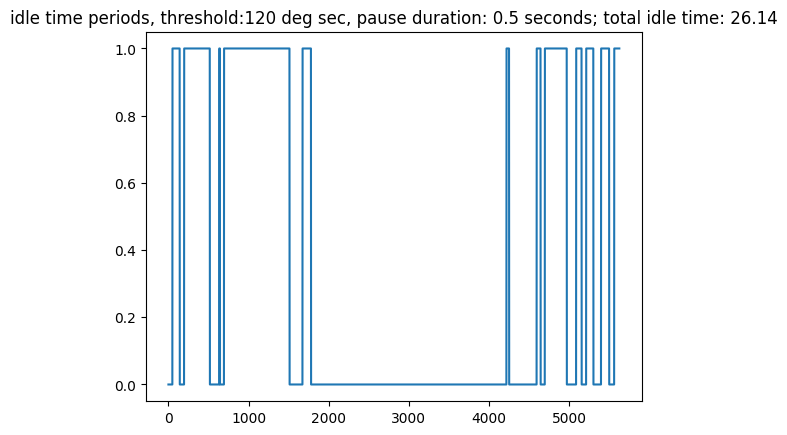

In [81]:
total_idle_time_m, idle_instances_m, idle_periods_m = generate_Idle_time(vel_res, params)
plt.plot(idle_periods_m)
plt.title('idle time periods, threshold:120 deg sec, pause duration: 0.5 seconds; total idle time: {0}'.format(total_idle_time_m))

In [80]:
total_idle_time_m

26.14

## Calculating idle time based on linear acceleration

### calculating velocity 

In [179]:
def get_vel(ser, samp_rate):
    prev_velocity = 0
    out = [prev_velocity]
    for i in range(1, len(ser)):
        curr_vel = (ser[i]/ samp_rate) + prev_velocity
        out.append(curr_vel)
        prev_velocity = curr_vel 
    return out

In [205]:
ibx = lambda x: np.array(x) - 2
iby = lambda x: np.array(x) - 2
ibz = lambda x: np.array(x) - 9.8

x_w_vel = get_vel(ibx(x_w), 100)
y_w_vel = get_vel(iby(y_w), 100)
z_w_vel = get_vel(ibz(z_w), 100)

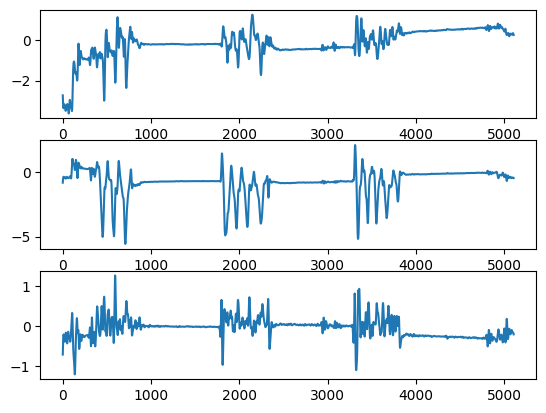

In [206]:
f, axs = plt.subplots(3)
axs[0].plot(ibx(x_w))
axs[1].plot(iby(y_w))
axs[2].plot(ibz(z_w))

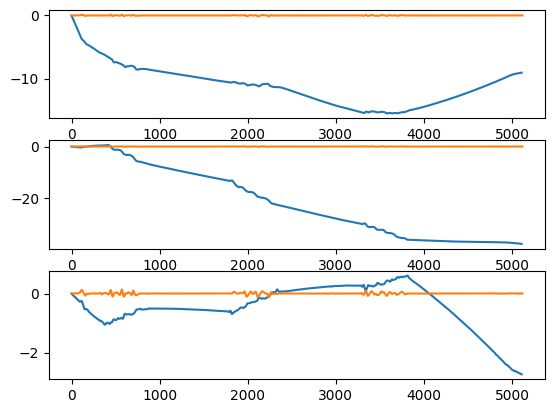

In [215]:
f, axs = plt.subplots(3)
axs[0].plot(x_w_vel)
axs[1].plot(y_w_vel)
axs[2].plot(z_w_vel)
axs[0].plot(vel_x)
axs[1].plot(vel_x)
axs[2].plot(vel_x)

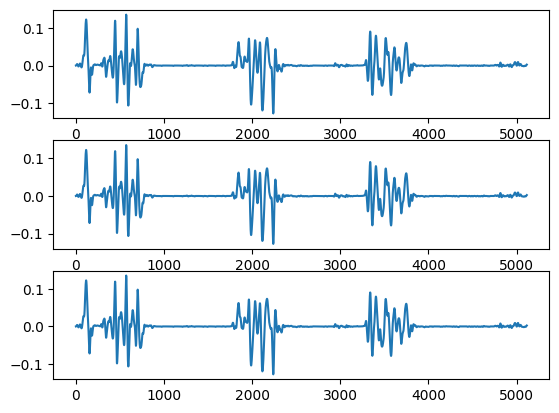

In [200]:
f, axs = plt.subplots(3)
axs[0].plot(vel_x)
axs[1].plot(vel_x)
axs[2].plot(vel_x)

In [185]:
vel_res_w = np.sqrt((np.square(x_w_vel)) + (np.square(y_w_vel)) + (np.square(z_w_vel)))

In [186]:
total_idle_time_w, idle_instances_w, idle_periods_w = generate_Idle_time(vel_res_w, params)

In [187]:
total_idle_time_m

35.0

([<matplotlib.axis.XTick at 0x29d120b20>,
 [Text(1, 0, 'RF'), Text(2, 0, 'accelerometer')])

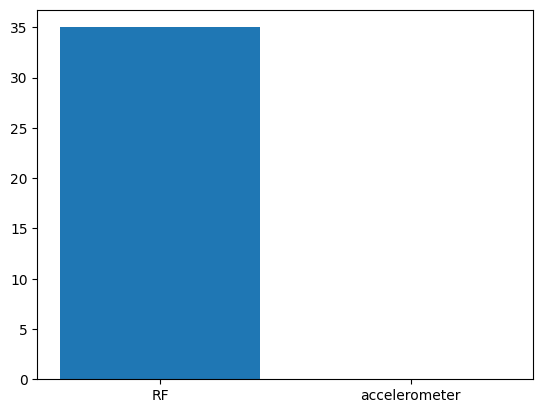

In [188]:
plt.bar([1, 2], [total_idle_time_m, total_idle_time_w])
plt.xticks([1, 2], ['RF', 'accelerometer'])

## What does acc generated from RF and accelerometer look like

In [195]:
len(x_w)

5108

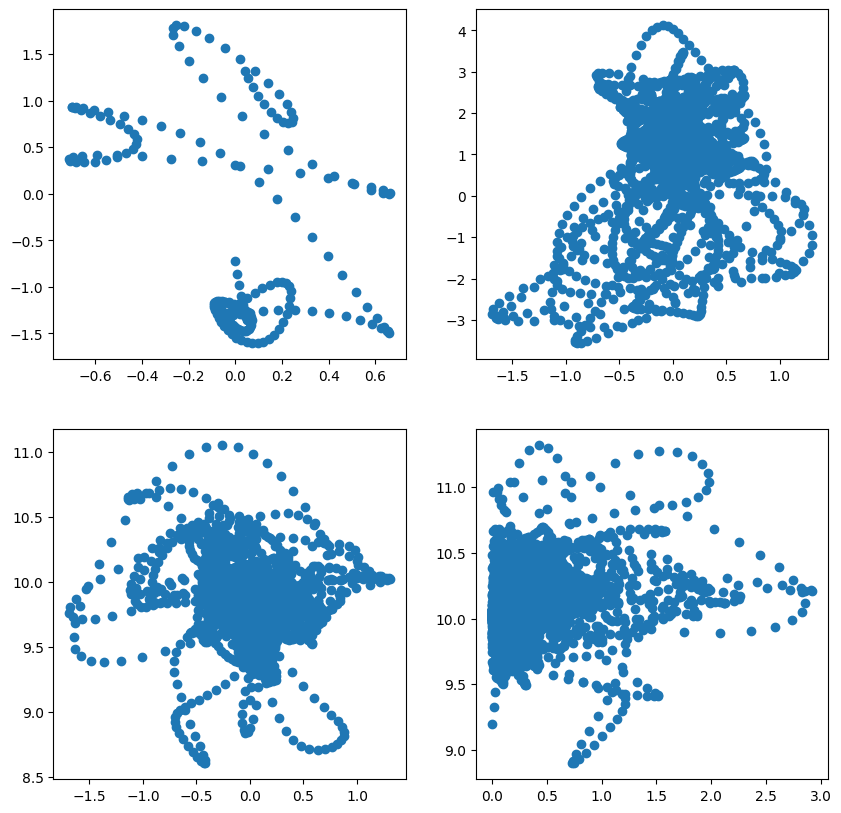

In [199]:
f, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0][0].scatter(acc_x[:200], x_w[:200])
axs[0][1].scatter(acc_y[:5108], y_w)
axs[1][0].scatter(acc_z[:5108], z_w)

acc_mag_m = np.sqrt((np.square(acc_x)) + (np.square(acc_y)) + (np.square(acc_z)))
acc_mag_w = np.sqrt((np.square(x_w)) + (np.square(y_w)) + (np.square(z_w)))

axs[1][1].scatter(acc_mag_m[:5108], acc_mag_w)

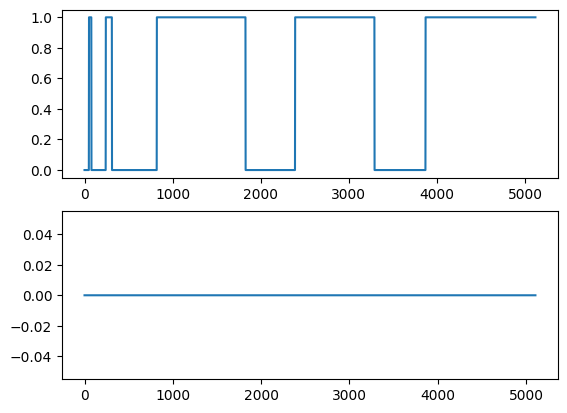

In [190]:
f, axs = plt.subplots(2)
axs[0].plot(idle_periods_m)
axs[1].plot(idle_periods_w)

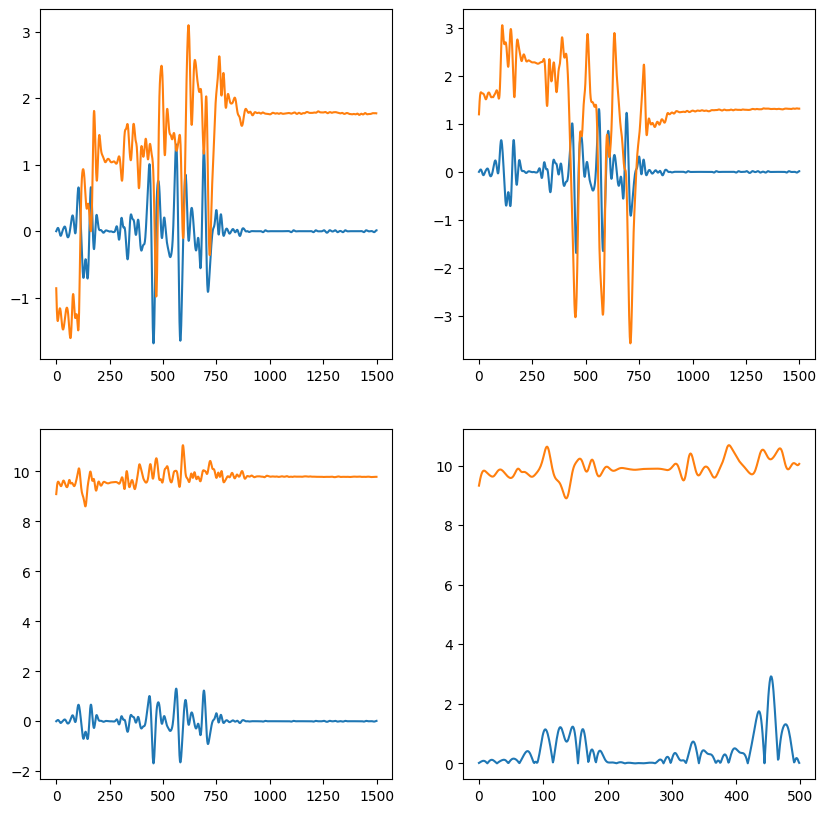

In [193]:
f, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0][0].plot(acc_x[:1500])
axs[0][0].plot(x_w[1:1500])

axs[0][1].plot(acc_y[:1500])
axs[0][1].plot(y_w[:1500])

axs[1][0].plot(acc_z[:1500])
axs[1][0].plot(z_w[:1500])

acc_mag_m = np.sqrt((np.square(acc_x)) + (np.square(acc_y)) + (np.square(acc_z)))
acc_mag_w = np.sqrt((np.square(x_w)) + (np.square(y_w)) + (np.square(z_w)))

axs[1][1].plot(acc_mag_m[1:500])
axs[1][1].plot(acc_mag_w[1:500])

### &#9658; <font color=red> Observation: acceleration plots look better. There seems tp ne some agreement in x plot (second low spike), same in yplot; idle periods seem similar <font/>

## Calculating idle time with angular velocity 